In [1]:
#set up environment
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import re
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
from transformers import BertForSequenceClassification, BertConfig
from transformers import BertPreTrainedModel, BertModel
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
from IPython.display import clear_output

In [2]:
from sklearn.model_selection import train_test_split
import random

In [2]:
PRETRAINED_MODEL_NAME = "bert-base-chinese"  

# get tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

clear_output()
print("PyTorch version：", torch.__version__)

PyTorch version： 1.12.1


In [3]:
print("PyTorch version：", torch.__version__)

PyTorch version： 1.12.1


# Data Cleaning

In [6]:
file_path = '12345_raw_data.xlsx'
data = pd.read_excel(file_path)

# extract the features and labels
classification_data = data[['来电内容', '举报专项']]

# show first rows
print(classification_data.head())

                                                来电内容    举报专项
0  市民于2023-12-17 ，反映违法建房占道种树和村民口粮地转租钱没发问题，见热线-231...  治理违法建设
1  市民反映，朝阳区网信大厦B座和霄云路辅路交叉口的地方，有卖麻辣烫的，还有个老奶奶卖烤肠的没有...  占道经营整治
2  市民反映，在房山区城关街道吉兴苑1号楼10单元3楼302是群租房，里面居住了很多人，非常的影...   群租房治理
3  工单来源：微信服务号，此工单内容为网民留言时填写的标题及原文。 \n============...  治理违法建设
4  市民反映，位于通州区宋庄镇北京工商大学嘉华学院南门存在街头游商现象，市民希望能够帮助得到解决...  占道经营整治


In [4]:
# save as json
json_file_path = 'data_to_json.json'
classification_data.to_json(json_file_path, orient='records', force_ascii=False)

In [45]:
with open(json_file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(df.head())

                                                来电内容    举报专项
0  市民于2023-12-17 ，反映违法建房占道种树和村民口粮地转租钱没发问题，见热线-231...  治理违法建设
1  市民反映，朝阳区网信大厦B座和霄云路辅路交叉口的地方，有卖麻辣烫的，还有个老奶奶卖烤肠的没有...  占道经营整治
2  市民反映，在房山区城关街道吉兴苑1号楼10单元3楼302是群租房，里面居住了很多人，非常的影...   群租房治理
3  工单来源：微信服务号，此工单内容为网民留言时填写的标题及原文。 \n============...  治理违法建设
4  市民反映，位于通州区宋庄镇北京工商大学嘉华学院南门存在街头游商现象，市民希望能够帮助得到解决...  占道经营整治


In [27]:
df.info

<bound method DataFrame.info of                                                      来电内容      举报专项
0       市民于2023-12-17 ，反映违法建房占道种树和村民口粮地转租钱没发问题，见热线-231...    治理违法建设
1       市民反映，朝阳区网信大厦B座和霄云路辅路交叉口的地方，有卖麻辣烫的，还有个老奶奶卖烤肠的没有...    占道经营整治
2       市民反映，在房山区城关街道吉兴苑1号楼10单元3楼302是群租房，里面居住了很多人，非常的影...     群租房治理
3       工单来源：微信服务号，此工单内容为网民留言时填写的标题及原文。 \n============...    治理违法建设
4       市民反映，位于通州区宋庄镇北京工商大学嘉华学院南门存在街头游商现象，市民希望能够帮助得到解决...    占道经营整治
...                                                   ...       ...
255204  市民反映，在海淀区上庄镇海淀嘉俊小区与三嘉信苑小区之间红绿灯垃圾桶处有一辆白色轿车正在售卖水...    占道经营整治
255205  市民反映，在丰台区太平桥街道万泉盛景园7号楼3单元704，房间内有打隔断，里面居住了四户人。...     群租房治理
255206  市民反映，自家住在海淀区田村路街道阜石路兰德华庭2号楼1单元，市民称小区新换了物业，小区内没...  地下空间清理整治
255207  市民反映，2022年12月23日10:40海淀区海淀医院进口处旁边有夫妻两个人烤红薯和卖板栗...    占道经营整治
255208  市民反映，大兴区旧宫云龙家园21栋1单元602室，存在群租房，已经反映过没有处理，希望尽快给...     群租房治理

[255209 rows x 2 columns]>

In [29]:
df.sample(10)

,来电内容,举报专项
12539,市民反映，之前于2023-11-29 反映小区地库出入口只开放一个问题，见热线-231129...,地下空间清理整治
199014,工单来源：微信服务号，此工单内容为网民留言时填写的标题及原文。 \n============...,治理违法建设
9908,市民反映，顺义区南彩镇九王庄村，村内有个村民（不清楚名字）住在48号，在公共区域搭建违建，并...,治理违法建设
197336,市民反映，平谷区金海湖镇祖务村有外村人在购买土地建墙圈占，希望帮助处理，来电反映圈占土地问题...,治理违法建设
122327,市民反映，东城区南颂年胡同5号楼3单元501，是2室1厅和阁楼，客厅被打成隔断，一共居住7个...,治理违法建设
48124,市民反映，在朝阳区丰和乡常营中路远洋3期1号，此地的围挡市民怀疑是超出范围了，怀疑有一些侵占...,施工围挡治理
102119,市民反映，延庆区（还没分属于哪个街乡镇）碧桂园小区2期40号楼111地下室，地下室严重漏水，...,地下空间清理整治
15793,市民反映，通州区张家湾镇里二泗村227号属于违建，期间自己反馈过此事，村委会回复自己称该房屋...,治理违法建设
29333,市民反映，于10月31日反映希望大队把合同剩余钱财退还给自己及违建问题。 见热线-23103...,治理违法建设
32889,工单来源：微信服务号，此工单内容为网民留言时填写的标题及原文。 \n============...,治理违法建设


In [78]:
# notice some data has missing values, upon checking the original data, consider this as invalid data.
def clean_text(text):
    if text.startswith('工单来源：'):
        # 移除 "工单来源：" 开头一直到 "=" 结束的部分
        text = re.sub(r"工单来源：.*?={2,}", "", text, flags=re.DOTALL)
        text = text.lstrip('\n').replace('\n留言', '')
        # 检查结尾是否有“-”，如果有，移除“-”之后的所有内容
        text = re.sub(r"-.*$", "", text, flags=re.DOTALL)
    text = re.sub(r"工单流转.*$", "", text, flags=re.DOTALL)
    return text

# apply
df['来电内容'] = df['来电内容'].apply(clean_text)

# display
df.head()

,来电内容,举报专项
0,市民于2023-12-17 ，反映违法建房占道种树和村民口粮地转租钱没发问题，见热线-231...,治理违法建设
1,市民反映，朝阳区网信大厦B座和霄云路辅路交叉口的地方，有卖麻辣烫的，还有个老奶奶卖烤肠的没有...,占道经营整治
2,市民反映，在房山区城关街道吉兴苑1号楼10单元3楼302是群租房，里面居住了很多人，非常的影...,群租房治理
3,\n留言标题：对12345回复有疑问，请人工联系本人，谢谢\n留言原文：2023.12.21...,治理违法建设
4,市民反映，位于通州区宋庄镇北京工商大学嘉华学院南门存在街头游商现象，市民希望能够帮助得到解决...,占道经营整治


In [79]:
#  View null values
df.isna().sum()

来电内容    0
举报专项    0
dtype: int64

In [80]:
df.describe()

,来电内容,举报专项
count,255209,255209
unique,245080,11
top,朝阳路和十里堡路丁字路口西北角，去年盖起一违章建筑，面积约130平米。室内装有空调，照明。要...,治理违法建设
freq,55,139736


In [81]:
duplicates = df[df.duplicated('来电内容', keep=False)]

# sort to adjacent
duplicates = duplicates.sort_values('来电内容')

# display
print(duplicates)

                                                     来电内容    举报专项
210406  \n\n\n海淀区天阅西山社区存在几十处违法建设，这些违建与社区规划建设方案严重不符，但是规...  治理违法建设
210630  \n\n\n海淀区天阅西山社区存在几十处违法建设，这些违建与社区规划建设方案严重不符，但是规...  治理违法建设
210639  \n\n\n海淀区天阅西山社区存在几十处违法建设，这些违建与社区规划建设方案严重不符，但是规...  治理违法建设
210687  \n\n\n海淀区天阅西山社区存在几十处违法建设，这些违建与社区规划建设方案严重不符，但是规...  治理违法建设
244528  \n\n\n社区内部大量非法的建筑自收房之日起一直存在至今，群众多次投诉举报，相关部门就是一...  治理违法建设
...                                                   ...     ...
250177               静安里中街能仁居三村烧烤距是否有建筑规划许可，什么时候能提供产权相关资料  治理违法建设
250178               静安里中街能仁居三村烧烤距是否有建筑规划许可，什么时候能提供产权相关资料  治理违法建设
250179               静安里中街能仁居三村烧烤距是否有建筑规划许可，什么时候能提供产权相关资料  治理违法建设
253151  顺义区牛栏山史家口村赵瑞占到私搭乱建，堆积杂物，致使我多年无法通行，存在严重安全隐患。该问题...  治理违法建设
250756  顺义区牛栏山史家口村赵瑞占到私搭乱建，堆积杂物，致使我多年无法通行，存在严重安全隐患。该问题...  治理违法建设

[16070 rows x 2 columns]


In [82]:
# check if the duplicated feature has the same label
duplicates_grouped = duplicates.groupby('来电内容')['举报专项'].nunique()
different_labels = duplicates_grouped[duplicates_grouped > 1].index
different_labels_data = duplicates[duplicates['来电内容'].isin(different_labels)]

print(different_labels_data)



                                                     来电内容      举报专项
558      \n留言标题：投诉紫竹院街道\n留言原文：在悦园地下室群租治理或地下室违规出租方面，紫竹院...  地下空间清理整治
5913     \n留言标题：投诉紫竹院街道\n留言原文：在悦园地下室群租治理或地下室违规出租方面，紫竹院...  地下空间清理整治
9488     \n留言标题：投诉紫竹院街道\n留言原文：在悦园地下室群租治理或地下室违规出租方面，紫竹院...  地下空间清理整治
14187    \n留言标题：投诉紫竹院街道\n留言原文：在悦园地下室群租治理或地下室违规出租方面，紫竹院...  地下空间清理整治
19279    \n留言标题：投诉紫竹院街道\n留言原文：在悦园地下室群租治理或地下室违规出租方面，紫竹院...     群租房治理
...                                                   ...       ...
252361  紫郡兰园小区13-2-102业主将地下仓储改造用于居住，违规破坏房屋主体结构且占用消防通道，...  地下空间清理整治
252711  紫郡兰园小区13-2-102业主将地下仓储改造用于居住，违规破坏房屋主体结构且占用消防通道，...    治理违法建设
252712  紫郡兰园小区13-2-102业主将地下仓储改造用于居住，违规破坏房屋主体结构且占用消防通道，...  地下空间清理整治
255123  \n海保发打着便民惠民的旗号非法开餐饮\n\n海淀区保障性住房发展有限公司身为区属重点国企，...    治理违法建设
255146  \n海保发打着便民惠民的旗号非法开餐饮\n\n海淀区保障性住房发展有限公司身为区属重点国企，...  无证无照经营整治

[309 rows x 2 columns]


In [87]:
df = df[~df['来电内容'].isin(different_labels)]

In [88]:
duplicates = df[df.duplicated('来电内容', keep=False)]

# sort to adjacent
duplicates = duplicates.sort_values('来电内容')

# display
print(duplicates)

                                                     来电内容    举报专项
210687  \n\n\n海淀区天阅西山社区存在几十处违法建设，这些违建与社区规划建设方案严重不符，但是规...  治理违法建设
210639  \n\n\n海淀区天阅西山社区存在几十处违法建设，这些违建与社区规划建设方案严重不符，但是规...  治理违法建设
210630  \n\n\n海淀区天阅西山社区存在几十处违法建设，这些违建与社区规划建设方案严重不符，但是规...  治理违法建设
210406  \n\n\n海淀区天阅西山社区存在几十处违法建设，这些违建与社区规划建设方案严重不符，但是规...  治理违法建设
244412  \n\n\n社区内部大量非法的建筑自收房之日起一直存在至今，群众多次投诉举报，相关部门就是一...  治理违法建设
...                                                   ...     ...
250179               静安里中街能仁居三村烧烤距是否有建筑规划许可，什么时候能提供产权相关资料  治理违法建设
250178               静安里中街能仁居三村烧烤距是否有建筑规划许可，什么时候能提供产权相关资料  治理违法建设
250177               静安里中街能仁居三村烧烤距是否有建筑规划许可，什么时候能提供产权相关资料  治理违法建设
250756  顺义区牛栏山史家口村赵瑞占到私搭乱建，堆积杂物，致使我多年无法通行，存在严重安全隐患。该问题...  治理违法建设
253151  顺义区牛栏山史家口村赵瑞占到私搭乱建，堆积杂物，致使我多年无法通行，存在严重安全隐患。该问题...  治理违法建设

[15761 rows x 2 columns]


In [91]:
df = df.drop_duplicates()

In [92]:
df

,来电内容,举报专项
0,市民于2023-12-17 ，反映违法建房占道种树和村民口粮地转租钱没发问题，见热线-231...,治理违法建设
1,市民反映，朝阳区网信大厦B座和霄云路辅路交叉口的地方，有卖麻辣烫的，还有个老奶奶卖烤肠的没有...,占道经营整治
2,市民反映，在房山区城关街道吉兴苑1号楼10单元3楼302是群租房，里面居住了很多人，非常的影...,群租房治理
3,\n留言标题：对12345回复有疑问，请人工联系本人，谢谢\n留言原文：2023.12.21...,治理违法建设
4,市民反映，位于通州区宋庄镇北京工商大学嘉华学院南门存在街头游商现象，市民希望能够帮助得到解决...,占道经营整治
...,...,...
255204,市民反映，在海淀区上庄镇海淀嘉俊小区与三嘉信苑小区之间红绿灯垃圾桶处有一辆白色轿车正在售卖水...,占道经营整治
255205,市民反映，在丰台区太平桥街道万泉盛景园7号楼3单元704，房间内有打隔断，里面居住了四户人。...,群租房治理
255206,市民反映，自家住在海淀区田村路街道阜石路兰德华庭2号楼1单元，市民称小区新换了物业，小区内没...,地下空间清理整治
255207,市民反映，2022年12月23日10:40海淀区海淀医院进口处旁边有夫妻两个人烤红薯和卖板栗...,占道经营整治


In [96]:
df = df.reset_index(drop=True)

In [97]:
data_dict = df.to_dict(orient='records')

json_file_name = 'data_cleaned.json'

with open(json_file_name, 'w') as json_file:
    json.dump(data_dict, json_file)

# Bert Tokens

In [95]:
with open(json_file_name, 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(df.head())

                                                来电内容    举报专项
0  市民于2023-12-17 ，反映违法建房占道种树和村民口粮地转租钱没发问题，见热线-231...  治理违法建设
1  市民反映，朝阳区网信大厦B座和霄云路辅路交叉口的地方，有卖麻辣烫的，还有个老奶奶卖烤肠的没有...  占道经营整治
2  市民反映，在房山区城关街道吉兴苑1号楼10单元3楼302是群租房，里面居住了很多人，非常的影...   群租房治理
3  \n留言标题：对12345回复有疑问，请人工联系本人，谢谢\n留言原文：2023.12.21...  治理违法建设
4  市民反映，位于通州区宋庄镇北京工商大学嘉华学院南门存在街头游商现象，市民希望能够帮助得到解决...  占道经营整治


In [99]:
df['举报专项'].unique()

array(['治理违法建设', '占道经营整治', '群租房治理', '无证无照经营整治', '地下空间清理整治',
       '区域性市场（区域性市场疏解提升、商圈商场改造）', '施工围挡治理', '发展老年餐桌', '建设提升基本便民服务网点',
       '"开墙打洞"整治', '桥下空间治理提升'], dtype=object)

In [103]:
bert_chinese_tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [126]:
class ComplaintsDataset(Dataset):
    def __init__(self, mode, tokenizer, json_file_name, split_ratio=0.8):
        assert mode in ["train", "val"]  # 改为 "train" 和 "val"
        self.mode = mode
        with open(json_file_name, 'r', encoding='utf-8') as f:
            data = json.load(f)
        df = pd.DataFrame(data)

        # 分割数据集为训练集和验证集
        train_df, val_df = train_test_split(df, train_size=split_ratio, random_state=42)
        self.df = train_df if mode == "train" else val_df
        self.len = len(self.df)

        # 创建标签映射
        self.label_map = {label: i for i, label in enumerate(df['举报专项'].unique())}
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['来电内容']
        label = self.df.iloc[idx]['举报专项']
        label_id = self.label_map[label]
        label_tensor = torch.tensor(label_id)

        # 对文本进行分词
        word_pieces = ["[CLS]"]
        tokens = self.tokenizer.tokenize(text)
        word_pieces += tokens + ["[SEP]"]
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        # 由于只有一个句子，所有的 token 都属于同一句
        segments_tensor = torch.tensor([0] * len(word_pieces), dtype=torch.long)

        return (tokens_tensor, segments_tensor, label_tensor)

    def __len__(self):
        return self.len



In [151]:
json_file_name = 'data_cleaned.json'
# 使用中文 BERT 分词器初始化训练集
trainset = ComplaintsDataset("train", tokenizer, json_file_name, split_ratio=0.8)
valset = ComplaintsDataset("val", tokenizer, json_file_name, split_ratio=0.8)

In [132]:
# 选择第一个样本
sample_idx = 0

# 从数据集中取出原始文本和标签进行比较
text, label = trainset.df.iloc[sample_idx][['来电内容', '举报专项']]

# 利用刚才建立的 Dataset 取出转换后的 id tensors
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# 将 tokens_tensor 还原成文本
tokens = bert_chinese_tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = "".join(tokens)

# 渲染前后差异
print(f"""[原始文本]
内容：{text}
分类：{label}

--------------------

[Dataset 返回的 tensors]
tokens_tensor  ：{tokens_tensor}

segments_tensor：{segments_tensor}

label_tensor   ：{label_tensor}

--------------------

[还原 tokens_tensors]
{combined_text}
""")  


[原始文本]
内容：市民反映，海淀区西北旺镇永丰屯村手机店都是无照经营，市民表示已经很长时间了，市民之前没有联系过其他部门，市场监管局也只是关了没有营业执照的饭店，其他店铺没有关闭，来电反映店铺无照经营问题
注：市民要求保密个人信息（已解释）。
分类：无证无照经营整治

--------------------

[Dataset 返回的 tensors]
tokens_tensor  ：tensor([ 101, 2356, 3696, 1353, 3216, 8024, 3862, 3895, 1277, 6205, 1266, 3200,
        7252, 3719,  705, 2254, 3333, 2797, 3322, 2421, 6963, 3221, 3187, 4212,
        5307, 5852, 8024, 2356, 3696, 6134, 4850, 2347, 5307, 2523, 7270, 3198,
        7313,  749, 8024, 2356, 3696,  722, 1184, 3766, 3300, 5468, 5143, 6814,
        1071,  800, 6956, 7305, 8024, 2356, 1767, 4664, 5052, 2229,  738, 1372,
        3221, 1068,  749, 3766, 3300, 5852,  689, 2809, 4212, 4638, 7649, 2421,
        8024, 1071,  800, 2421, 7215, 3766, 3300, 1068, 7308, 8024, 3341, 4510,
        1353, 3216, 2421, 7215, 3187, 4212, 5307, 5852, 7309, 7579, 3800, 8038,
        2356, 3696, 6206, 3724,  924, 2166,  702,  782,  928, 2622, 8020, 2347,
        6237, 7025, 8021,  511,  102])

segments_tensor：tensor([0, 0, 0, 0, 0, 0, 0,

In [155]:
# 这个函数的输入 `samples` 是一个列表，其中的每个元素都是
# `ComplaintsDataset` 返回的一个样本，每个样本都包含 3 个张量：
# - tokens_tensor
# - segments_tensor
# - label_tensor
# 它将对 tokens_tensor 进行 zero padding，并生成 masks_tensors


# 定义 create_mini_batch 函数（如果尚未定义）
def create_mini_batch(samples, max_seq_length=512):
    tokens_tensors = [s[0] for s in samples]
    masks_tensors = [s[1] for s in samples]

    # 截断超长序列
    tokens_tensors = [t if t.size(0) <= max_seq_length else t[:max_seq_length] for t in tokens_tensors]
    masks_tensors = [m if m.size(0) <= max_seq_length else m[:max_seq_length] for m in masks_tensors]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None

    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    masks_tensors = pad_sequence(masks_tensors, batch_first=True)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)

    return tokens_tensors, masks_tensors, label_ids

# 设置批处理大小
BATCH_SIZE = 32

#
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=lambda x: create_mini_batch(x, max_seq_length=512), shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=lambda x: create_mini_batch(x, max_seq_length=512))



In [156]:
len(trainloader)

196004

In [135]:
data = next(iter(trainloader))

tokens_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")



tokens_tensors.shape   = torch.Size([32, 558]) 
tensor([[ 101, 2356, 3696,  ...,    0,    0,    0],
        [ 101, 2356, 3696,  ...,    0,    0,    0],
        [ 101, 2356, 3696,  ...,    0,    0,    0],
        ...,
        [ 101, 2356, 3696,  ...,    0,    0,    0],
        [ 101, 2356, 3696,  ...,    0,    0,    0],
        [ 101, 2356, 3696,  ...,    0,    0,    0]])
------------------------
masks_tensors.shape    = torch.Size([32, 558])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
------------------------
label_ids.shape        = torch.Size([32])
tensor([0, 1, 1, 0, 1, 1, 0, 0, 4, 4, 2, 6, 0, 1, 1, 0, 0, 2, 0, 1, 4, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0])



# Bert Training

In [136]:
# 加载一个可以进行中文文本分类的预训练模型，num_labels 应该是您的标签数量
PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = len(trainset.label_map)  # 假设您的标签数量等于 trainset 中不同标签的数量

# 加载预训练模型和配置
config = BertConfig.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, config=config)

# 显示此模型中的模块
print("name            module\n----------------------")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=11, bias=True)


In [149]:
class BertForSingleSequenceClassification(BertPreTrainedModel):
    def __init__(self, config, num_labels=2):
        super(BertForSingleSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)  # 加载预训练 BERT
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # 简单 linear 层
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        # BERT 输入就是 tokens 和 masks
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # 池化最后一层的 hidden state 的第一个 token 的输出
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        # 线性分类器将 dropout 后的 BERT 表示转成类别 logits
        logits = self.classifier(pooled_output)

        # 如果输入有 labels，则直接计算 Cross Entropy 并返回，方便！
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss

        # 返回各类别的 logits
        return logits

In [160]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # 确保模型在正确的设备上

# 训练模式
model.train()

# 使用 Adam Optimizer 更新整个分类模型的参数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 5
for epoch in range(EPOCHS):
    running_loss = 0.0
    model.train()  # 确保模型处于训练模式

    for data in trainloader:
        # 将数据移动到 GPU 上
        tokens_tensors, masks_tensors, labels = [t.to(device) for t in data]

        # 将参数梯度归零
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids=tokens_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs.loss
        # backward
        loss.backward()
        optimizer.step()

        # 记录当前 batch loss
        running_loss += loss.item()

    # 计算在训练集上的分类准确率
    _, train_acc = get_predictions(model, trainloader, compute_acc=True)

    # 计算在验证集上的分类准确率
    model.eval()  # 设置模型为评估模式
    _, val_acc = get_predictions(model, valloader, compute_acc=True)

    print(f'[epoch {epoch + 1}] loss: {running_loss:.3f}, train acc: {train_acc:.3f}, val acc: {val_acc:.3f}')


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

## 2. Modeling

Now, please perform feature engineering to build a model that can predict whether the users are active. (To get full credit, you need to make some visualization and try out several different models using cross validation)

RandomForestClassifier Cross-Validation Accuracy: 0.7769
LogisticRegression Cross-Validation Accuracy: 0.7170
AdaBoostClassifier Cross-Validation Accuracy: 0.7813


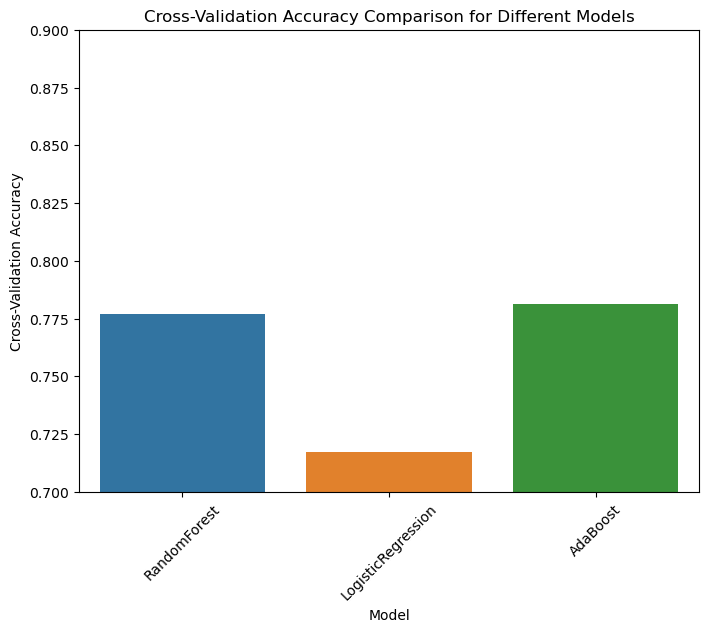

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

# Normalize all features
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)

seed = 0
models = [RandomForestClassifier(n_estimators=50,
                                 max_depth=10,
                                 oob_score=True,
                                 class_weight="balanced", 
                                 random_state=seed),
          LogisticRegression(penalty = "l2",
                             C = 1,
                             fit_intercept=True,
                            #  class_weight="balanced",
                             solver = 'newton-cholesky',
                             random_state=seed), 
          AdaBoostClassifier(n_estimators=100,
                             learning_rate=0.85,
                             algorithm="SAMME.R",
                             random_state=seed)]
scores_list = []

for model in models:
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    scores_list.append(scores)
    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {scores.mean():.4f}")

plt.figure(figsize=(8, 6))
models_names = ['RandomForest', 'LogisticRegression', 'AdaBoost']
scores_means = [scores.mean() for scores in scores_list]
sns.barplot(x=models_names, y=scores_means)
plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy Comparison for Different Models')
plt.xticks(rotation=45)
plt.ylim(0.7, 0.9)
plt.show()


## 3. Model Evaluation

The bottom line here is: Was the model useful? You need to check both **numerical metrics and visual metrics**. **Please explain different performance metrics and your results.**

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Build an AdaBoostClassifier and perform cross-validation
adaboost_model = AdaBoostClassifier(n_estimators=100,
                             learning_rate=0.85,
                             algorithm="SAMME.R",
                             random_state=seed)
adaboost_scores = cross_val_score(adaboost_model, X_scaled, y, cv=5, scoring='accuracy')

# Output cross-validation accuracy.
print(f"AdaBoost cross-validation accuracy： {adaboost_scores.mean():.4f}")

AdaBoost cross-validation accuracy： 0.7813


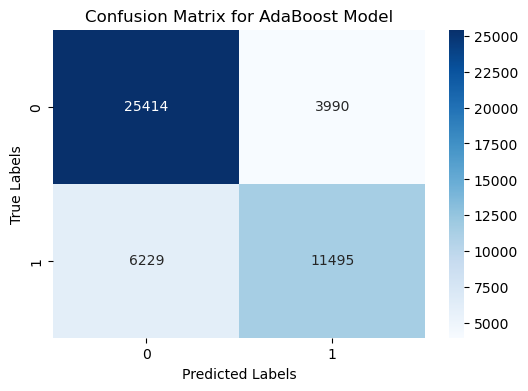

In [21]:
# Train the model using the entire dataset and make predictions.
adaboost_model.fit(X_scaled, y)
y_pred = adaboost_model.predict(X_scaled)
# Calculate the confusion matrix.
conf_matrix = confusion_matrix(y, y_pred)
# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for AdaBoost Model')
plt.show()

Accuracy is an evaluation metric for classification models, reflecting the percentage of correct predictions out of all predictions made.

Precision is another metric, spotlighting the proportion of accurately predicted positive samples among all samples predicted as positive. It underlines the veracity of positive predictions.

Recall quantifies a classifier's competence in accurately identifying positive samples. It emphasizes the number of positive samples correctly predicted out of the total true positive samples.

Given their respective areas of focus, precision and recall are frequently employed evaluation metrics in classification problems. As they concurrently examine the precision of predictions and the capacity to correctly identify positive samples, it's important to consider both metrics for a well-rounded evaluation.

In [22]:
# Output classification report.
class_report = classification_report(y, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.86      0.83     29404
        True       0.74      0.65      0.69     17724

    accuracy                           0.78     47128
   macro avg       0.77      0.76      0.76     47128
weighted avg       0.78      0.78      0.78     47128



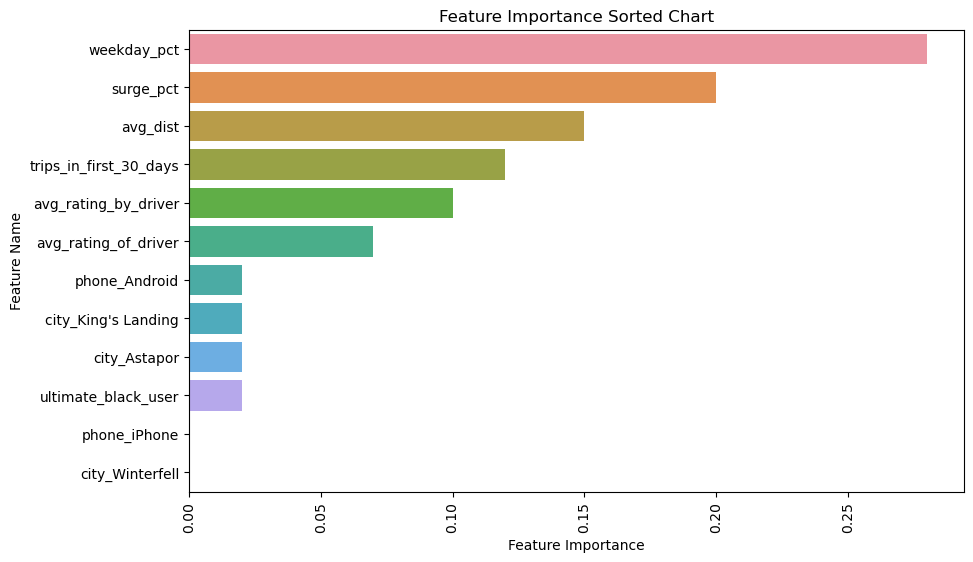

In [23]:
 # Get feature importance and sort it.
feature_importance = adaboost_model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]

# Visualize based on the sorted feature importance.
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_indices], y=X.columns[sorted_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance Sorted Chart')
plt.xticks(rotation=90)
plt.show()

"Feature importance" denotes a measurement utilized in machine learning models to gauge the influence of input features on the predictive results of the model. This metric assists in determining which features substantially impact the model's decision-making process. As indicated by the graph, weekday_pct emerges as the most significant feature, corroborating our intuitive supposition.

## 4. Final Submission




The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions` (contains 0 and 1s). 

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. 



### Submission on Gitea

Please push all your work (ipynb, submission.csv) to the `-final` repo on Gitea. All your work should be on the master branch. 

### Submission on Canvas

Just in case you have issues with Git, submit the same items on Canvas.




In [24]:
# Load and preprocess test data
test = pd.read_csv('data/test.csv')
# Fill missing values in avg_rating_by_driver and avg_rating_of_driver
test['avg_rating_by_driver'].fillna(test['avg_rating_by_driver'].mean(), inplace=True)
test['avg_rating_of_driver'].fillna(test['avg_rating_of_driver'].mean(), inplace=True)
test_encoded = pd.get_dummies(test)
test_encoded = test_encoded[X.columns]
test_scaled = scaler.transform(test_encoded)
# Make predictions on the test data
test_predictions = adaboost_model.predict(test_scaled)

In [25]:
submission_df = pd.DataFrame({ 
    "active": test_predictions
}, columns=['active'])
submission_df.to_csv("submission.csv", index=False)

print('Created a CSV file: submission.csv')
print('You may now upload this CSV file to Gitea for grading.')

Created a CSV file: submission.csv
You may now upload this CSV file to Gitea for grading.
